In [1]:
import warnings

warnings.filterwarnings("ignore")
import utils

from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.constants import CMAP_IMPACT
from climada.util.plot import plot_from_gdf
import numpy as np
import matplotlib.pyplot as plt

client = Client()
haz_tc_haiti = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)

# prepare exposure
exposure = client.get_litpop(country="Haiti")

# prepare impact function
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])

In [2]:
# compute impact

impact = ImpactCalc(exposure, impf_set, haz_tc_haiti).impact(save_mat=True)

test_return_periods = np.geomspace(.01, 500, 100)

# local exceedance impact
local_exceedance_impact, label, title = impact.local_exceedance_impact(
    return_periods=test_return_periods, method="extrapolate_constant", #method="extrapolate" method="extrapolate_constant"
)

In [3]:
from return_period_maps import ReturnPeriodMap, ExceedanceCurve
rp_map = ReturnPeriodMap.from_CLIMADA_local_exceedance_intensity(local_exceedance_impact)

<Axes: >

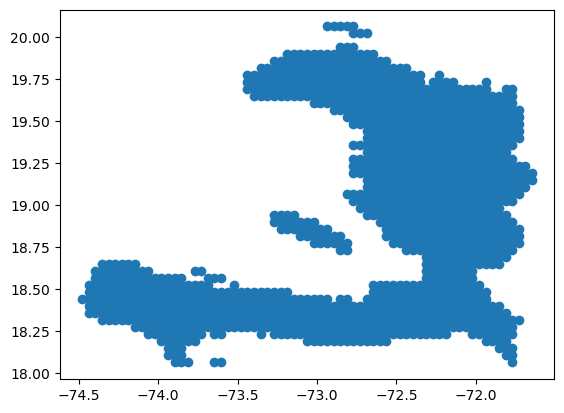

In [4]:
rp_map.geometry.plot()

In [84]:
cf_test = 1
for cfactor in [-.3, -.3 , -.1, 0., 0., 0., 0.5, 0.5, 0.95, 0.95]:
    rp_map_half =  rp_map.coarsen(scale_factor=1.5, kwargs_combine_exceedance_curves={
        "coincidence_fraction": cf_test, "n_samples": 10000, "correlation_factor": cfactor
    })
    print("AAI coarsened", rp_map_half.compute_aai_aggregated(coincidence_fraction=cf_test)/1_000_000)

print("AAI original", rp_map.compute_aai_aggregated(coincidence_fraction=cf_test)/1_000_000)

AAI coarsened 186.19364150788448
AAI coarsened 195.28391101772823
AAI coarsened 201.4644011973284
AAI coarsened 189.23778902017452
AAI coarsened 194.21403059159664
AAI coarsened 193.32168863028068
AAI coarsened 194.46539212797484
AAI coarsened 184.82879083660058
AAI coarsened 198.44643713108903
AAI coarsened 188.63992229600277
AAI original 191.26191196170652


In [ ]:
"""
cfraction = 0.001

AAI coarsened 188.58142271283447
AAI coarsened 168.67296634945293
AAI coarsened 238.69089856164635
AAI coarsened 191.1809631184571
AAI coarsened 224.90404980173767
AAI coarsened 157.14631712428942
AAI coarsened 203.65854461349062
AAI coarsened 151.6436576959342
AAI coarsened 155.17051241723615
AAI coarsened 165.41125160218897

AAI original 192.99767390268812
"""

"""
cfraction = 1

AAI coarsened 186.19364150788448
AAI coarsened 195.28391101772823
AAI coarsened 201.4644011973284
AAI coarsened 189.23778902017452
AAI coarsened 194.21403059159664
AAI coarsened 193.32168863028068
AAI coarsened 194.46539212797484
AAI coarsened 184.82879083660058
AAI coarsened 198.44643713108903
AAI coarsened 188.63992229600277
AAI original 191.26191196170652
"""